In [14]:
import pandas as pd

# Load dataset
file_path = "D:/dm_assignment/datasets/confusion_matrix.csv"
df = pd.read_csv(file_path)

print("Dataset shape:", df.shape)
print(df.head())

# Features and target
X = df.drop("price_range", axis=1)
y = df["price_range"]

Dataset shape: (2000, 21)
   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15   

   three_g  

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Define model
xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")

# Hyperparameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=xgb, param_grid=param_grid,
    scoring="accuracy", cv=3, verbose=1, n_jobs=-1
)

# Train
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [17:06:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       150
           1       0.93      0.93      0.93       150
           2       0.88      0.90      0.89       150
           3       0.95      0.94      0.95       150

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



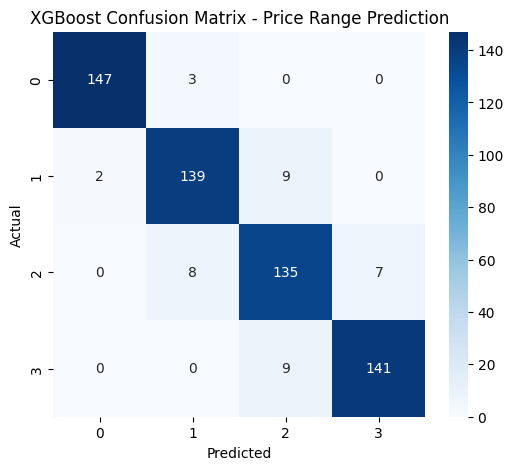

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = best_model.predict(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix - Price Range Prediction")
plt.show()

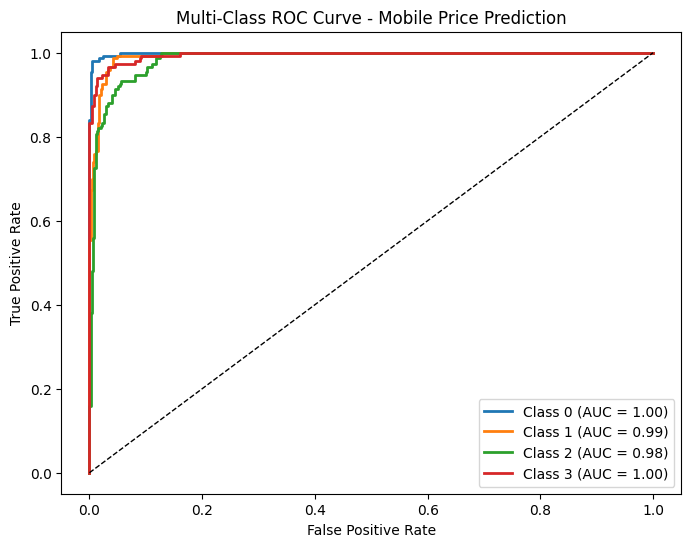

In [17]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels for multi-class ROC
n_classes = len(y.unique())
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
y_pred_prob = best_model.predict_proba(X_test)

# Compute ROC curve & AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves
plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve - Mobile Price Prediction")
plt.legend()
plt.show()